# Exploring Ensemble Methods with Decision Trees on Loan Lending dataset

### Fire up Graphlab Create

In [1]:
import graphlab

### Load LendingClub dataset

In [2]:
loans = graphlab.SFrame('lending-club-data.gl/')

This non-commercial license of GraphLab Create for academic use is assigned to agrawal.pr@husky.neu.edu and will expire on March 12, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\agraw\AppData\Local\Temp\graphlab_server_1506404392.log.0


In [4]:
# features
loans.column_names()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'is_inc_v',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'not_compliant',
 'status',
 'inactive_loans',
 'bad_loans',
 'emp_length_num',
 'grade_num',
 'sub_grade_num',
 'delinq_2yrs_zero',
 'pub_rec

## Modifying the target column

The target column (label column) of the dataset that we are interested in is `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

We reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [5]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.remove_column('bad_loans')

## Selecting features

We will be using a subset of features (categorical and numeric) described below.

In [6]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

## Skipping observations with missing values

In [7]:
loans, loans_with_na = loans[[target] + features].dropna_split()

# Count the number of rows with missing data
num_rows_with_na = loans_with_na.num_rows()
num_rows = loans.num_rows()
print 'Dropping %s observations; keeping %s ' % (num_rows_with_na, num_rows)

Dropping 29 observations; keeping 122578 


## Make sure the classes are balanced

This dataset is imbalanced so we will undersample the larger class (safe loans) in order to balance out our dataset.

In [8]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(percentage, seed = 1)
risky_loans = risky_loans_raw
loans_data = risky_loans.append(safe_loans)

print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Percentage of safe loans                 : 0.502247166849
Percentage of risky loans                : 0.497752833151
Total number of loans in our new dataset : 46503


The dataset is balanced (approximately 50-50 safe vs risky loans).

## Split data into training and validation sets

We split the data into training data and validation data.

In [9]:
train_data, validation_data = loans_data.random_split(.8, seed=1)

# Gradient boosted tree classifier

Gradient boosted trees are a powerful variant of boosting methods. We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

We will now train models to predict `safe_loans` using the features above. In this section, we will experiment with training an ensemble of 5 trees. To cap the ensemble classifier at 5 trees, we call the function with **max_iterations=5** (recall that each iterations corresponds to adding a tree).

In [10]:
model_5 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 5)

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 37219

Number of classes           : 2

Number of feature columns   : 24

Number of unpacked features : 24

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.097257     | 0.657541          | 0.657139          |

| 2         | 0.164436     | 0.656976          | 0.636157          |

| 3         | 0.220586     | 0.664983          | 0.623206          |

| 4         | 0.286762     | 0.668476          | 0.613783          |

| 5         | 0.388031     | 0.673339          | 0.606229          |

+-----------+--------------+-------------------+-------------------+

# Making predictions

Let's consider a few positive and negative examples **from the validation set**. We will do the following:
* Predict whether or not a loan is likely to default.
* Predict the probability with which the loan is likely to default.

In [11]:
# Select all positive and negative examples.
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

# Select 2 examples from the validation set for positive & negative loans
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

# Append the 4 examples into a single dataset
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

Columns:
	safe_loans	int
	grade	str
	sub_grade_num	float
	short_emp	int
	emp_length_num	int
	home_ownership	str
	dti	float
	purpose	str
	payment_inc_ratio	float
	delinq_2yrs	int
	delinq_2yrs_zero	int
	inq_last_6mths	int
	last_delinq_none	int
	last_major_derog_none	int
	open_acc	int
	pub_rec	int
	pub_rec_zero	int
	revol_util	float
	total_rec_late_fee	float
	int_rate	float
	total_rec_int	float
	annual_inc	int
	funded_amnt	int
	funded_amnt_inv	int
	installment	float

Rows: 4

Data:
+------------+-------+---------------+-----------+----------------+----------------+
| safe_loans | grade | sub_grade_num | short_emp | emp_length_num | home_ownership |
+------------+-------+---------------+-----------+----------------+----------------+
|     1      |   B   |      0.2      |     0     |       3        |    MORTGAGE    |
|     1      |   B   |      0.6      |     1     |       1        |      RENT      |
|     -1     |   D   |      0.4      |     0     |       3        |      RENT      |
|     -1     |   A   |      1.0      |     0     |       11       |    MORTGAGE    |
+------------+-------+---------------+-----------+----------------+----------------+
+-------+--------------------+-------------------+-------------+------------------+
|  dti  |      purpose       | payment_inc_ratio | delinq_2yrs | delinq_2yrs_zero |
+-------+--------------------+-------------------+-------------+------------------+
| 29.44 |    credit_card     |      6.30496      |      0      |        1         |
| 12.19 |    credit_card     |      13.4952      |      0      |        1         |
| 13.97 |       other        |      2.96736      |      3      |        0         |
| 16.33 | debt_consolidation |      1.90524      |      0      |        1         |
+-------+--------------------+-------------------+-------------+------------------+
+----------------+------------------+-----------------------+----------+---------+
| inq_last_6mths | last_delinq_none | last_major_derog_none | open_acc | pub_rec |
+----------------+------------------+-----------------------+----------+---------+
|       0        |        1         |           1           |    8     |    0    |
|       0        |        1         |           1           |    8     |    0    |
|       0        |        0         |           1           |    14    |    0    |
|       0        |        1         |           1           |    17    |    0    |
+----------------+------------------+-----------------------+----------+---------+
+--------------+------------+--------------------+----------+-----+
| pub_rec_zero | revol_util | total_rec_late_fee | int_rate | ... |
+--------------+------------+--------------------+----------+-----+
|      1       |    93.9    |        0.0         |   9.91   | ... |
|      1       |    59.1    |        0.0         |  11.71   | ... |
|      1       |    59.5    |        0.0         |  16.77   | ... |
|      1       |    62.1    |        0.0         |   8.9    | ... |
+--------------+------------+--------------------+----------+-----+
[4 rows x 25 columns]

### Predicting on sample validation data

In [12]:
model_5.predict(sample_validation_data)

dtype: int
Rows: 4
[1L, 1L, -1L, 1L]

**We got 3 predictions correct out of 4 which gives us 75% accuracy**

### Prediction probabilities
Probability of any instance being classified as a safe loan.

In [14]:
model_5.predict(sample_validation_data, output_type='probability')

dtype: float
Rows: 4
[0.7045905590057373, 0.5963408946990967, 0.44925159215927124, 0.6119099855422974]

**The instance that was predicted as risky (-1) by our model is the same instance which has the lowest probability of being classified as a safe loan**

## Evaluating the model on the validation data

Accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Evaluate the accuracy of the **model_5** on the **validation_data**.

In [15]:
model_5.evaluate(validation_data)

{'accuracy': 0.66813873330461,
 'auc': 0.7247215702188436,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      -1      |        1        |  1618 |
 |      -1      |        -1       |  3054 |
 |      1       |        -1       |  1463 |
 |      1       |        1        |  3149 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.6715001599317625,
 'log_loss': 0.6176131769648966,
 'precision': 0.6605831760016782,
 'recall': 0.6827840416305291,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 4612 | 4672 |
 |   1e-05   | 1.0 | 1.0 | 4612 | 4672 |
 |   2e-05   | 1.0 | 

Number of **false positives** made by the model.

In [16]:
graphlab.canvas.set_target('ipynb')
model_5.show(view='Evaluation')

## Most positive & negative loans.

In this section, we will find the loans that are most likely to be predicted **safe** in following steps:

* **Step 1**: Use the **model_5** (the model with 5 trees) and make **probability predictions** for all the loans in the **validation_data**.
* **Step 2**: Add the probability predictions as a column called **predictions** into the validation_data.
* **Step 3**: Sort the data (in descreasing order) by the probability predictions.

In [19]:
# step 1
probability_predictions = model_5.predict(validation_data, output_type = 'probability')
# step 2
validation_data['predictions'] = probability_predictions

### Top 5 loans with the highest probability of being predicted as a **safe loan**.

In [24]:
# step 3
validation_data[['grade','predictions']].sort('predictions', ascending=False)[0:5]

grade,predictions
A,0.848508358002
A,0.848508358002
A,0.841295421124
A,0.841295421124
A,0.841295421124


### Top 5 loans with the **lowest probability** of being predicted as a **safe loan**:

In [26]:
validation_data[['grade','predictions']].sort('predictions', ascending=True)[0:5]

grade,predictions
D,0.134275108576
C,0.134275108576
B,0.134275108576
C,0.134275108576
C,0.134275108576


# Effect of adding more trees

Now we will train 5 different ensemble classifiers in the form of gradient boosted trees. We will train models with 10, 50, 100, 200, and 500 trees.  We use the **max_iterations** parameter in the boosted tree module.

In [28]:
model_10 = graphlab.boosted_trees_classifier.create(train_data, validation_set = None, target = target, 
                                                    features = features, max_iterations = 10, verbose = False)

In [30]:
model_50 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, target = target, 
                                                   features = features, max_iterations = 50, verbose = False)
model_100 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, target = target, 
                                                   features = features, max_iterations = 100, verbose = False)
model_200 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, target = target, 
                                                   features = features, max_iterations = 200, verbose = False)
model_500 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, target = target, 
                                                   features = features, max_iterations = 500, verbose = False)

## Compare accuracy on entire validation set of all the models

In [33]:
print "Accuracy of model with 10 trees: ", model_10.evaluate(validation_data)['accuracy']
print "Accuracy of model with 50 trees: ", model_50.evaluate(validation_data)['accuracy']
print "Accuracy of model with 100 trees: ", model_100.evaluate(validation_data)['accuracy']
print "Accuracy of model with 200 trees: ", model_200.evaluate(validation_data)['accuracy']
print "Accuracy of model with 500 trees: ", model_500.evaluate(validation_data)['accuracy']

Accuracy of model with 10 trees:  0.672770357604
Accuracy of model with 50 trees:  0.690758293839
Accuracy of model with 100 trees:  0.691727703576
Accuracy of model with 200 trees:  0.684510986644
Accuracy of model with 500 trees:  0.671800947867


**Hence, Model with 100 trees has the best accuracy which also proves that just by having more trees in the model will not result in greater accuracy**

# Plotting training and validation error vs number of trees

Classification error is defined as

$$
\mbox{classification error} = 1 - \mbox{accuracy} 
$$

We will plot the **training and validation errors versus the number of trees** to get a sense of how these models are performing. We will compare the 10, 50, 100, 200, and 500 tree models.

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [40]:
training_errors = [] # consists of classification errors of all the models on train data
training_errors.append(1 - model_10.evaluate(train_data)['accuracy'])
training_errors.append(1 - model_50.evaluate(train_data)['accuracy'])
training_errors.append(1 - model_100.evaluate(train_data)['accuracy'])
training_errors.append(1 - model_200.evaluate(train_data)['accuracy'])
training_errors.append(1 - model_500.evaluate(train_data)['accuracy'])
print training_errors

[0.31174937531905744, 0.24605712136274482, 0.20043526155995595, 0.13643569144791634, 0.03823316048254921]


In [41]:
validation_errors = [] # consists of classification errors of all the models on validation data
validation_errors.append(1 - model_10.evaluate(validation_data)['accuracy'])
validation_errors.append(1 - model_50.evaluate(validation_data)['accuracy'])
validation_errors.append(1 - model_100.evaluate(validation_data)['accuracy'])
validation_errors.append(1 - model_200.evaluate(validation_data)['accuracy'])
validation_errors.append(1 - model_500.evaluate(validation_data)['accuracy'])
print validation_errors

[0.3272296423955192, 0.30924170616113744, 0.30827229642395515, 0.31548901335631196, 0.3281990521327014]


Now, we will plot the **training_errors** and **validation_errors** versus the number of trees. We will compare the 10, 50, 100, 200, and 500 tree models.

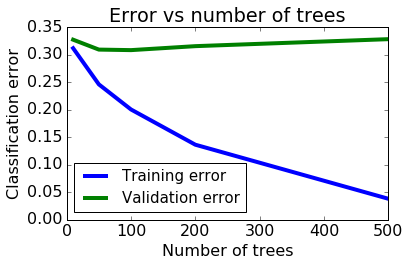

In [42]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

**So it's visible that the training error reduces as the number of trees in the model increases (in other words with increase in model complexity) but this is not the case with validation error which first reduces and then starts increasing.**